<a href="https://colab.research.google.com/github/bassemr/DeepLearningAndGenerativeModelsCourse/blob/main/ex8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FINETUNING

We exploit a complex model that was already trained on a big dataset (such as ImageNet) and we finetune it to classify our dataset.
In order to finetune the following steps are required:
- changing the last layer of the pretrained model in order to be on the same output size as our number of classes
- freezing (i.e. not training) the initial layers of the model
- train the last layers of the models on the new data

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [3]:
t = torch.randn(2,1,5,5)
print(t.reshape(t.size(0), -1).shape)

torch.Size([2, 25])


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
# Let's start by defining the model to finetune
# For this example we will use VGG11
import torchvision.models as models

# vgg11 = models.vgg11(weights='IMAGENET1K_V1') # load vgg model pretrained on ImageNet
# print(vgg11)
#weights = models.ResNet18_Weights.DEFAULT#
#resnet18 = models.resnet18(weights=weights)

#resnet18 = models.resnet18(weights='IMAGENET1K_V1')

alexnet = models.alexnet(weights='IMAGENET1K_V1') #if older version of pytorch: pretrained = True
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:02<00:00, 109MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
# define a function to freeze the model layers
def set_parameter_requires_grad(model, req_grad = False):
    for param in model.parameters():
        param.requires_grad = req_grad

In [7]:
!pip install torchinfo


In [8]:
from torchinfo import summary


summary(model=alexnet,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     23,296               True
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    307,392              True
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6)     

In [9]:
alexnet.features, alexnet.classifier


(Sequential(
   (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
   (1): ReLU(inplace=True)
   (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (4): ReLU(inplace=True)
   (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (7): ReLU(inplace=True)
   (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (9): ReLU(inplace=True)
   (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
 ),
 Sequential(
   (0): Dropout(p=0.5, inplace=False)
   (1): Linear(in_features=9216, out_features=4096, bias=True)
   (2): ReLU(inplace=True)
   (3): Dropout(p=0.5, inplace=False)
   (4): Linear(in_features=4096, out_fe

In [10]:
# classes in CIFAR10?
NUM_CLASSES = 10
# freeze model layers
set_parameter_requires_grad(alexnet.features, req_grad = False)
# change last layer of the model
num_ftrs = alexnet.classifier[6].in_features # get the input dimension of last layer
alexnet.classifier[6] = nn.Linear(num_ftrs,NUM_CLASSES)
input_size = 224 #model requires this input size

alexnet = alexnet.to(device)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
from torchinfo import summary


summary(model=alexnet,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     (23,296)             False
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    (307,392)            False
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6

In [12]:
# define the dataset again with correct input size
# define transforms
transform = transforms.Compose(
    [transforms.Resize(input_size),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # normalization parameteres tuned on ImageNet mean and var
# define batch size
batch_size = 4

# load train ds
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# load test ds
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 39.9MB/s]


In [13]:
len(trainloader), len(testloader), trainset.classes

(12500,
 2500,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [14]:
# TRAIN AGAIN!

# define Loss and Optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

for epoch in range(1):  # loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
      # stop after 2k iterations
      if i > 2000:
          break
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # put data on correct device
      inputs, labels = inputs.to(device), labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = alexnet(inputs) #finetuned model
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % 200 == 199:    # print every 200 mini-batches
          print(f'[it: {i + 1}] loss: {running_loss / 200:.3f}')
          running_loss = 0.0

  print('Finished Training')

[it: 200] loss: 1.463
[it: 400] loss: 0.974
[it: 600] loss: 0.939
[it: 800] loss: 0.823
[it: 1000] loss: 0.885
[it: 1200] loss: 0.887
[it: 1400] loss: 0.880
[it: 1600] loss: 0.814
[it: 1800] loss: 0.813
[it: 2000] loss: 0.864
Finished Training
[it: 200] loss: 0.770
[it: 400] loss: 0.743
[it: 600] loss: 0.771
[it: 800] loss: 0.842
[it: 1000] loss: 0.812
[it: 1200] loss: 0.761
[it: 1400] loss: 0.727
[it: 1600] loss: 0.770
[it: 1800] loss: 0.705
[it: 2000] loss: 0.817
Finished Training


In [15]:
!git clone https://github.com/bassemr/DeepLearningAndGenerativeModelsCourse.git


Cloning into 'DeepLearningAndGenerativeModelsCourse'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 548 (delta 29), reused 18 (delta 17), pack-reused 496 (from 3)
Receiving objects: 100% (548/548), 99.29 MiB | 27.39 MiB/s, done.
Resolving deltas: 100% (235/235), done.


In [16]:
# if you want to save the model
PATH = '/content/DeepLearningAndGenerativeModelsCourse/res/resfinetuned_cifar_net.pth'
torch.save(alexnet.state_dict(), PATH)

# if you want to load the model
#alexnet.load_state_dict(torch.load(PATH))

In [17]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "resfinetuned_cifar_net.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=alexnet.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/resfinetuned_cifar_net.pth


In [18]:
# now lets evaluate the model on the test set
correct = 0
total = 0

# put the model into evaluation mode
alexnet.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader):
        inputs, labels = data
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = alexnet(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'It: {i}')

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

It: 199
It: 399
It: 599
It: 799
It: 999
It: 1199
It: 1399
It: 1599
It: 1799
It: 1999
It: 2199
It: 2399
Accuracy of the network on the 10000 test images: 79 %


## Features visualization
Let's try to visualize the features in the dataset before and after the training

In [19]:
# we will use TSNE as a tool to visualize high-dimensional data
from sklearn.manifold import TSNE #pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

In [20]:
alexnet,  alexnet.classifier[:3]


(AlexNet(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
     (1): ReLU(inplace=True)
     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (4): ReLU(inplace=True)
     (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU(inplace=True)
     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU(inplace=True)
     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
   (classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=9216, out_feature

In [21]:
import numpy as np
# get the features extractors from vgg
features_extractor = alexnet.features
avg_pool = alexnet.avgpool
out_features = alexnet.classifier[:3]
# initialize features and labels list
features_list = []
labels_list = []
with torch.no_grad():
    for i, data in enumerate(testloader):
        inputs, labels = data
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = out_features(torch.flatten(avg_pool(features_extractor(inputs)),1))

        #flatten outputs
        outputs = outputs.view(outputs.size(0), -1)


        current_outputs = outputs.cpu().numpy()
        current_labels = labels.cpu().numpy()
        # create features list
        features_list.append(current_outputs)
        labels_list.append(current_labels)
        if i % 200 == 199:    # get only 200 batches
            break

In [22]:
(labels_list[0])

array([3, 8, 8, 0])

In [23]:
features_list_cat = np.concatenate(features_list, axis=0)
labels_list_cat = np.concatenate(labels_list, axis=0)
print(features_list_cat.shape)
print(labels_list_cat.shape)

(800, 4096)
(800,)


In [24]:
len(features_list_cat[0])

4096

In [25]:
tsne = TSNE(n_components=2).fit_transform(features_list_cat)

In [26]:
print(tsne.shape)

(800, 2)


In [27]:
# scale and move the coordinates so they fit [-1; 1] range
def scale_to_11_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [-1; 1] by dividing by its range
    return 2*(starts_from_zero / value_range) - 1

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_11_range(tx)
ty = scale_to_11_range(ty)

tsne[:, 0] = tx
tsne[:, 1] = ty

In [29]:
import sys
sys.path.append("/content/DeepLearningAndGenerativeModelsCourse")
from res.plot_lib import plot_data, plot_data_np, plot_model, set_default
# Initiale default plotting parameters
set_default()

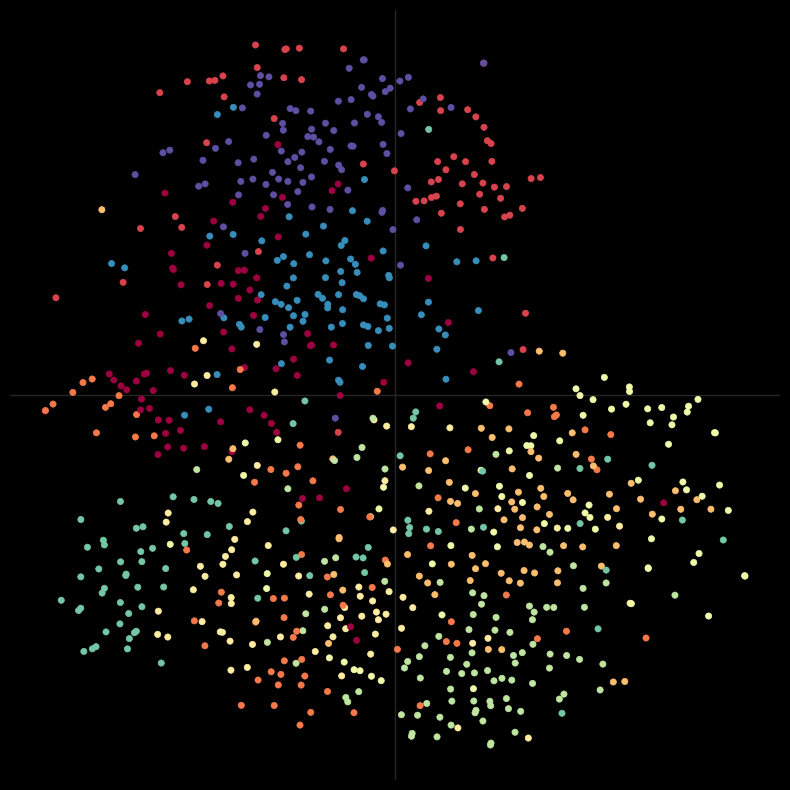

In [30]:
# plot classes
plot_data_np(tsne, labels_list_cat)

In [31]:
# let's try with the untrained network
alexnet_un = models.alexnet(weights = None).to(device)
alexnet_un.eval()

# get the features extractors from vgg
features_extractor = alexnet_un.features
avg_pool = alexnet_un.avgpool
out_features = alexnet_un.classifier[:3]
# initialize features and labels list
features_list = []
labels_list = []
with torch.no_grad():
    for i, data in enumerate(testloader):
        inputs, labels = data
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = out_features(torch.flatten(avg_pool(features_extractor(inputs)),1))
        #flatten outputs
        outputs = outputs.view(outputs.size(0), -1)

        current_outputs = outputs.cpu().numpy()
        current_labels = labels.cpu().numpy()
        # create features list
        features_list.append(current_outputs)
        labels_list.append(current_labels)
        if i % 200 == 199:    # get only 200 el
            break

In [32]:
features_list_cat = np.concatenate(features_list, axis=0)
labels_list_cat = np.concatenate(labels_list, axis=0)
print(features_list_cat.shape)
print(labels_list_cat.shape)

(800, 4096)
(800,)


In [ ]:
tsne = TSNE(n_components=2).fit_transform(features_list_cat)

In [33]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_11_range(tx)
ty = scale_to_11_range(ty)

tsne[:, 0] = tx
tsne[:, 1] = ty

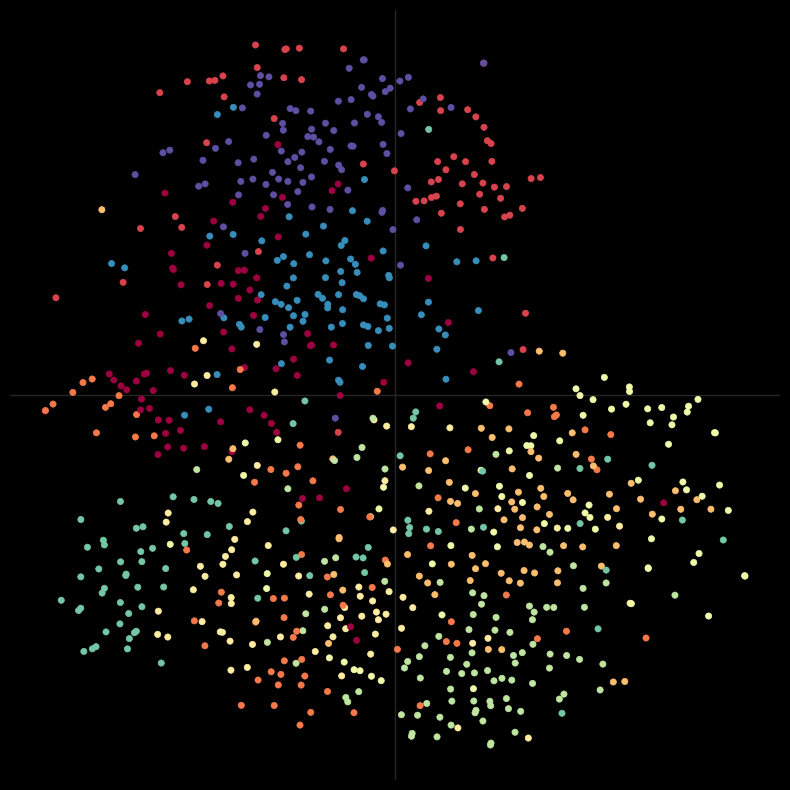

In [34]:
# plot classes
plot_data_np(tsne, labels_list_cat)

In [ ]:
# Ex1: do the finetuning using a resnet18 and vgg11

In [ ]:
# Ex2: try to train the full model (both pretrained and not pretrained) and not just the last layers.
# How the results are different?